In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import curve_fit

import emcee
import corner

from altaipony.fakeflares import flare_model
from altaipony.altai import equivalent_duration
from altaipony.flarelc import FlareLightCurve

from astropy import units as u
from astropy.modeling import models
from astropy.constants import sigma_sb

def flare_factor(teff, radius, wav, resp,  tflare=10000):
    """Calculate the flare energy factor in ergs, following Shibayama et al. (2013)

    Parameters
    ----------
    teff : float
        Stellar effective temperature in Kelvin.
    radius : float
        Stellar radius in solar radii.
    wav : array
        Array of wavelengths in nanometers.
    resp : array
        Array of bandpass responses.
     tflare : float
        Flare temperature in Kelvin.
    
    Returns
    -------
    factor : float
        Flare energy factor in ergs/s.
    """

    # blackbody
    bb = models.BlackBody(temperature=teff * u.K)

    # blackbody flux in TESS band
    bbwavs = bb(wav * u.nm)  * resp

    fluxs = np.trapz(bbwavs.value, wav)

    # blackbody
    bb = models.BlackBody(temperature=tflare * u.K)

    # blackbody flux in TESS band
    bbwavf = bb(wav * u.nm)  * resp

    fluxf = np.trapz(bbwavf.value, wav)

    ratio = fluxs / fluxf

    factor = ratio * np.pi * (radius * u.R_sun) ** 2 * sigma_sb * (tflare * u.K)**4

    return factor.to("erg/s")



In [74]:
# GET THE IMAGE DATA -----------------------------------------------------------
file = "20240415114752"
IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/hip67522_CHEOPS-products-{file}_im.fits'
hdulist = fits.open(IMG)
print(f"Imagette file found for {file}:\n {IMG}\n")


# get the image data
image_data = hdulist[1].data

t, f, ferr, roll = image_data["BJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"]

# make sure the data is in fact 10s cadence
assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

# big endian to little endian
t = t.byteswap().newbyteorder()
f = f.byteswap().newbyteorder()
ferr = ferr.byteswap().newbyteorder()
roll = roll.byteswap().newbyteorder()


Imagette file found for 20240415114752:
 ../data/hip67522/CHEOPS-products-20240415114752/Outdata/00000/hip67522_CHEOPS-products-20240415114752_im.fits



/tmp/ipykernel_18714/1826535474.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240415114752/Outdata/00000/hip67522_CHEOPS-products-20240415114752_im.fits'>
  hdulist = fits.open(IMG)


In [75]:
# input parameters

# read input from cheops_flares_input.csv
input_file = "../data/cheops_flares_input.csv"
df = pd.read_csv(input_file)

row = df[df["file"] == int(file)].iloc[0]

# get the parameters
egress = row.egress
ingress = row.ingress 
tmin = row.tmin
tmax = row.tmax
t_peak = row.t_peak
parametrization = row.parametrization

egress, ingress


(nan, 2460413.39403)

Initial mask: 1506 data points
Using the davenport2014 flare model
Egress mask: 1506 data points
Tmin, Tpeak, Tmax: (2460413.175, 2460413.182, 2460413.2)


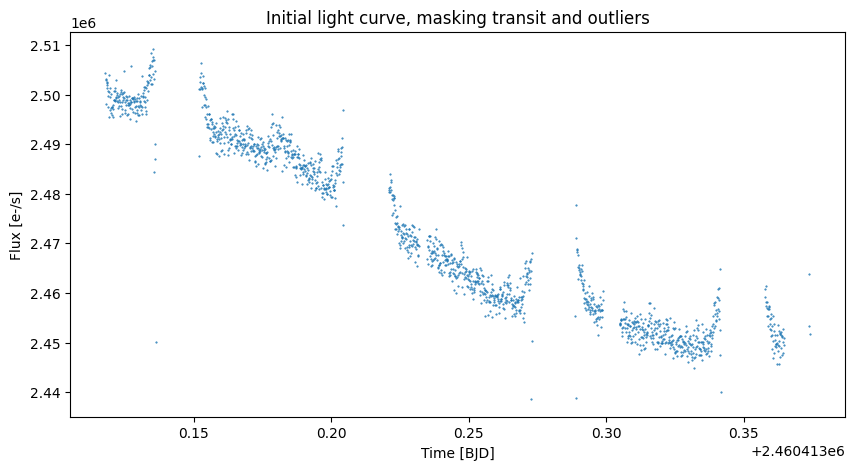

In [76]:
%matplotlib inline


if ~np.isnan(ingress):
    mask = (f < 2.9e6) & (f > 2.43e6) & (t < ingress - 0.02) 
elif ~np.isnan(egress):
    mask = (f < 2.9e6) & (f > 2.43e6) & (t > egress + 0.2)

t = t[mask]
f = f[mask]
roll = roll[mask]
ferr = ferr[mask]



print(f"Initial mask: {mask.sum()} data points")

print(f"Using the {parametrization} flare model")

print(f"Egress mask: {mask.sum()} data points")

print(f"Tmin, Tpeak, Tmax: {tmin, t_peak, tmax}")

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Initial light curve, masking transit and outliers")
plt.savefig(f"../plots/{file}/flares/hip67522_initial_lc.png")

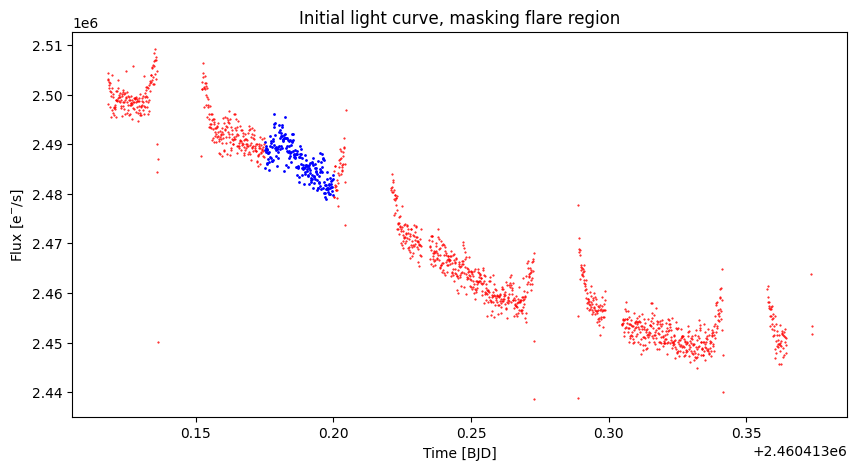

In [77]:
flare_mask = np.zeros_like(f, dtype=bool)

flare_mask[(t > tmin) & (t < tmax)] = True



plt.figure(figsize=(10, 5))
plt.plot(t[flare_mask], f[flare_mask], ".", markersize=2, color="blue")
plt.plot(t[~flare_mask], f[~flare_mask], ".", markersize=1, color="red")
plt.xlabel("Time [BJD]")
plt.ylabel(r"Flux [e$^{-}$/s]")
plt.title("Initial light curve, masking flare region")
plt.savefig(f"../plots/{file}/flares/hip67522_initial_lc_flare_mask.png")
# plt.xlim(2460392.7, 2460392.8)

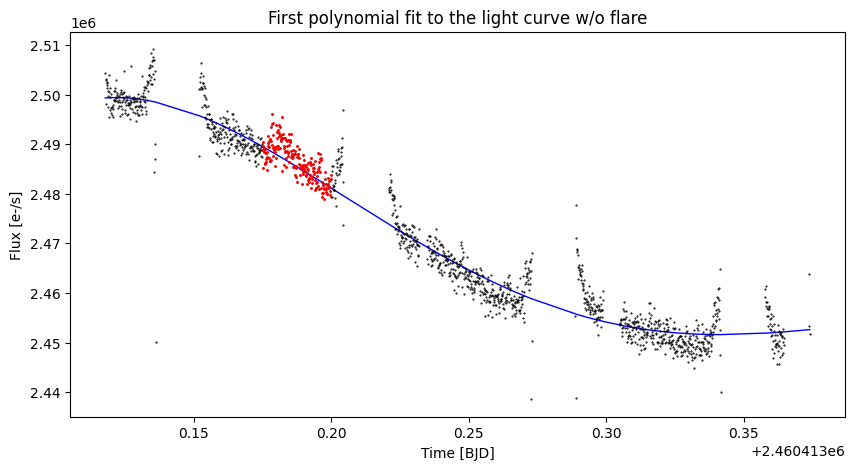

In [78]:

# 5th degree polynomial with a time offset
offset2 = t[0]
def func(x, a, b, c, d, e, f, offset):
    return (f * (x - offset2 + offset)**5 + 
            e * (x - offset2 + offset)**4 + 
            a * (x - offset2 + offset)**3 + 
            b * (x - offset2 + offset)**2 + 
            c * (x - offset2 + offset) + d
)

popt, pcov = curve_fit(func, t[~flare_mask], f[~flare_mask], p0=[-1.45888787e+04, -1.41685433e+08, -1.03596058e+09,  1.00000000e+00,
        1.19292031e-02, -2.42900480e-09,  8.42088604e-01])

fitted = func(t, *popt)



plt.figure(figsize=(10, 5))

plt.plot(t, fitted, color="blue", lw=1)
plt.plot(t, f, ".", markersize=1, color="black")
plt.plot(t[flare_mask], f[flare_mask], ".", markersize=2, color="red")

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("First polynomial fit to the light curve w/o flare")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_init.png")

Outliers: 91


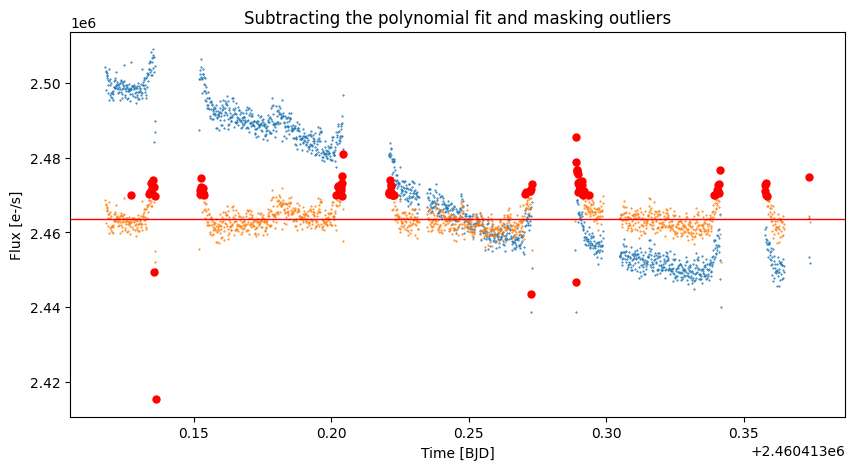

In [79]:
# subtract fitted from f
med = np.median(f[~flare_mask])
f_sub = f - fitted + med

mask_outliers = (f_sub[~flare_mask] > 1.0025 * med) | (f_sub[~flare_mask] < 0.995 * med)
print(f"Outliers: {mask_outliers.sum()}")

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)
plt.plot(t, f_sub, ".", markersize=1)
plt.axhline(med, color="red", lw=1)

# plot masked outliers
plt.plot(t[~flare_mask][mask_outliers], f_sub[~flare_mask][mask_outliers], ".", markersize=10, color="red")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Subtracting the polynomial fit and masking outliers")
plt.savefig(f"../plots/{file}/flares/hip67522_subtract_polyfit_init.png")


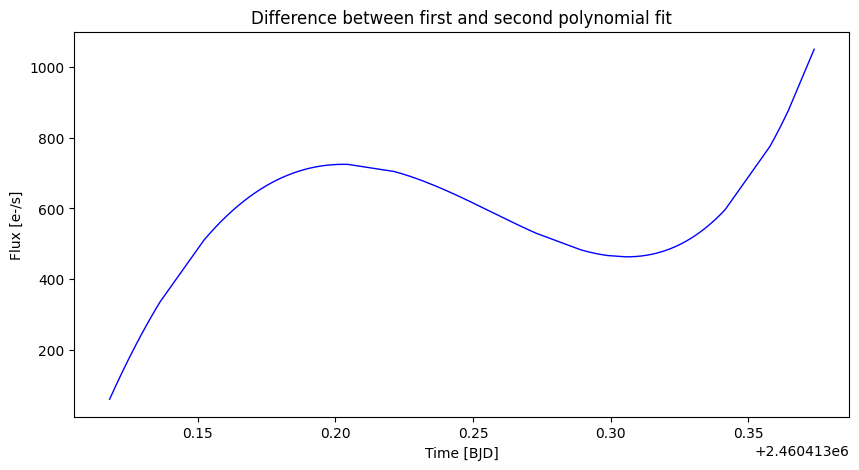

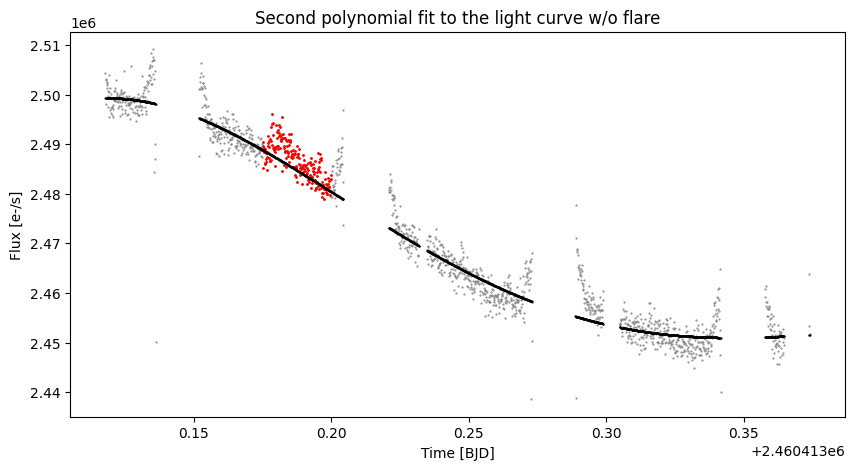

In [80]:
tnew = t[~flare_mask][~mask_outliers]
fnew = f[~flare_mask][~mask_outliers]
popt, pcov = curve_fit(func, tnew, fnew, p0=popt)

newfitted = func(t, *popt)


newmed = np.median(f[~flare_mask][~mask_outliers])
newf_sub = f - fitted + med


plt.figure(figsize=(10, 5))
plt.plot(t, fitted-newfitted, color="blue", lw=1)
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Difference between first and second polynomial fit")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_diff.png")

plt.figure(figsize=(10, 5))

plt.plot(t, f, ".", markersize=1, color="grey")
plt.plot(t[flare_mask], f[flare_mask], ".", markersize=2, color="red")
plt.plot(t, newfitted, ".", markersize=1, color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Second polynomial fit to the light curve w/o flare")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_final.png")


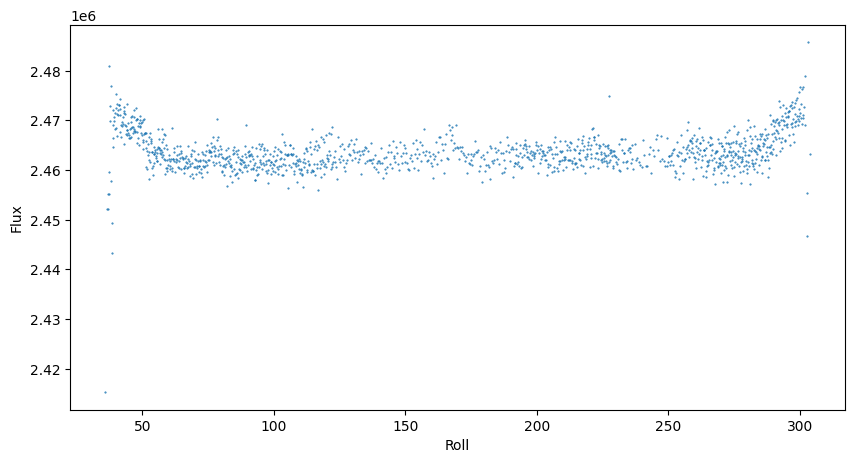

In [81]:
# plot f_sub against roll
plt.figure(figsize=(10, 5))
plt.plot(roll[~flare_mask], newf_sub[~flare_mask], ".", markersize=1)
plt.xlabel("Roll")
plt.ylabel("Flux")
plt.savefig(f"../plots/{file}/flares/hip67522_roll_flux.png")

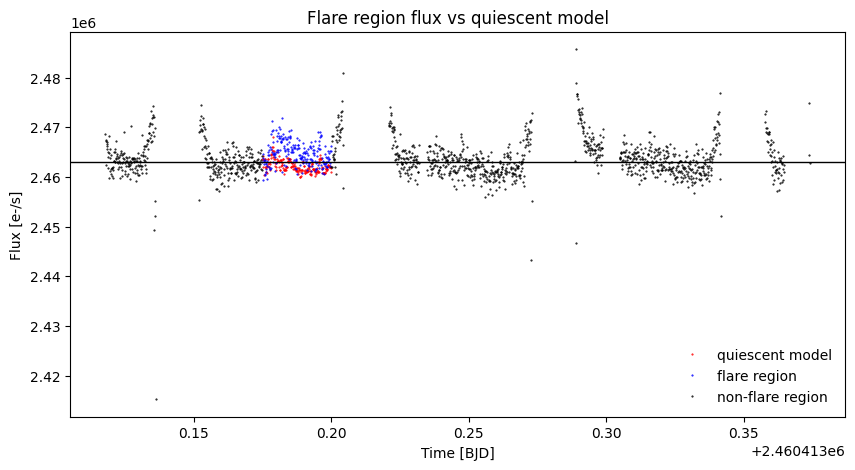

In [92]:
# approximate the flux at the roll values in the flare region with 
# the flux at the closest roll value in the non-flare region
f_sub_flare = newf_sub[flare_mask]
roll_flare = roll[flare_mask]

f_sub_no_flare = newf_sub[~flare_mask]
roll_no_flare = roll[~flare_mask]

f_sub_flare_approx = np.zeros_like(f_sub_flare)
for i, r in enumerate(roll_flare):
    
    idx = [np.argmin(np.abs(roll_no_flare - r-delt)) for delt in np.linspace(-1, 1, 50)]
    f_sub_flare_approx[i] = np.median(f_sub_no_flare[idx])


plt.figure(figsize=(10, 5))
plt.plot(t[flare_mask], f_sub_flare_approx, ".", markersize=1, color="red", label="quiescent model")
plt.plot(t[flare_mask], f_sub_flare, ".", markersize=1, color="blue", label="flare region")
plt.plot(t[~flare_mask], f_sub_no_flare, ".", markersize=1, color="black", label="non-flare region")
plt.axhline(newmed, color="black", lw=1)
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.legend(loc=0, frameon=False)
plt.title("Flare region flux vs quiescent model")
plt.savefig(f"../plots/{file}/flares/hip67522_flare_vs_quiescent_model.png")


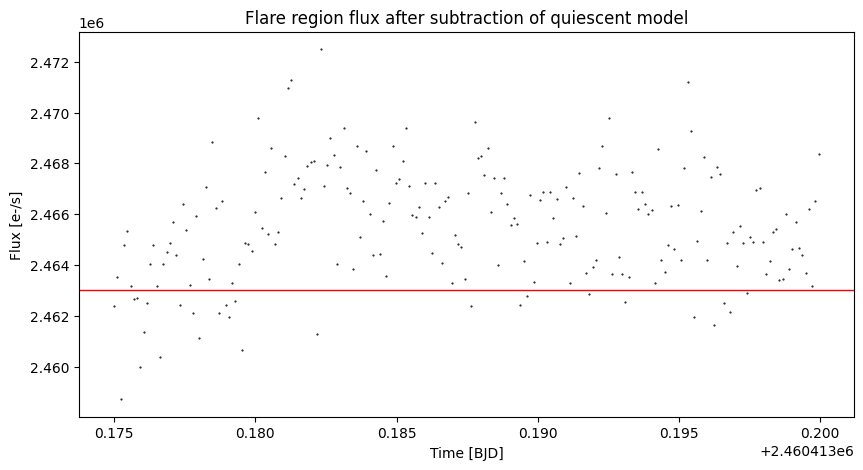

In [93]:
# subtract the interpolated flux from the flare region
f_flare = f_sub_flare - f_sub_flare_approx + newmed


plt.figure(figsize=(10, 5))
plt.plot(t[flare_mask], f_flare, ".", markersize=1, color="black")
plt.axhline(newmed, color="red", lw=1)

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Flare region flux after subtraction of quiescent model")
plt.savefig(f"../plots/{file}/flares/hip67522_flare_extracted.png")


In [94]:

dur = 0.01
ampl = 0.01*newmed

f = flare_model(parametrization, t[flare_mask], t_peak, dur, ampl)
#plt.plot(t[flare_mask], f, ".", markersize=1)
#plt.plot(t[flare_mask], f_flare-newmed, ".", markersize=1, color="black")

# fit the flare model to f_flare
def flare_fit_model(t, t_peak, dur, ampl):
    return flare_model(parametrization, t, t_peak, dur, ampl)

popt, pcov = curve_fit(flare_fit_model, t[flare_mask], f_flare-newmed, p0=[t_peak, dur, ampl], bounds=([tmin, 0, 0], [tmax,np.inf,np.inf]))

# plt.plot(t[flare_mask], flare_fit_model(t[flare_mask], *popt), ".", markersize=1, color="red")
# plt.plot(t[flare_mask], f_flare-med, ".", markersize=1, color="black")
print(popt, newmed)

[2.46041318e+06 1.76892084e-02 6.10182045e+03] 2463032.4896288877


In [95]:
# write an mcmc procedure to fit the flare model to the data
# use the emcee package



def log_likelihood(theta, t, f, ferrstd):
    t_peak, dur, ampl = theta
    model = flare_fit_model(t, t_peak, dur, ampl)
    return -0.5 * np.sum((f - model)**2 / ferrstd**2)

def log_prior(theta):
    t_peak, dur, ampl = theta
    if (t[flare_mask][0] < t_peak < t[flare_mask][-1]) and (0.0 < dur < 0.1) and (0.001 < ampl < 1e7):
        return 0.0
    return -np.inf

def log_probability(theta, t, f, ferrstd):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, f, ferrstd)

ndim = 3
nwalkers = 32
nsteps = 4000

pos = popt + 1e-4 * np.random.randn(nwalkers, ndim)

# define the standard deviation of the flux in the flare region using the non-flare region
ferrstd = np.std(newf_sub[~flare_mask])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t[flare_mask], f_flare-newmed, ferrstd))

sampler.run_mcmc(pos, nsteps, progress=True);


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:06<00:00, 601.46it/s]


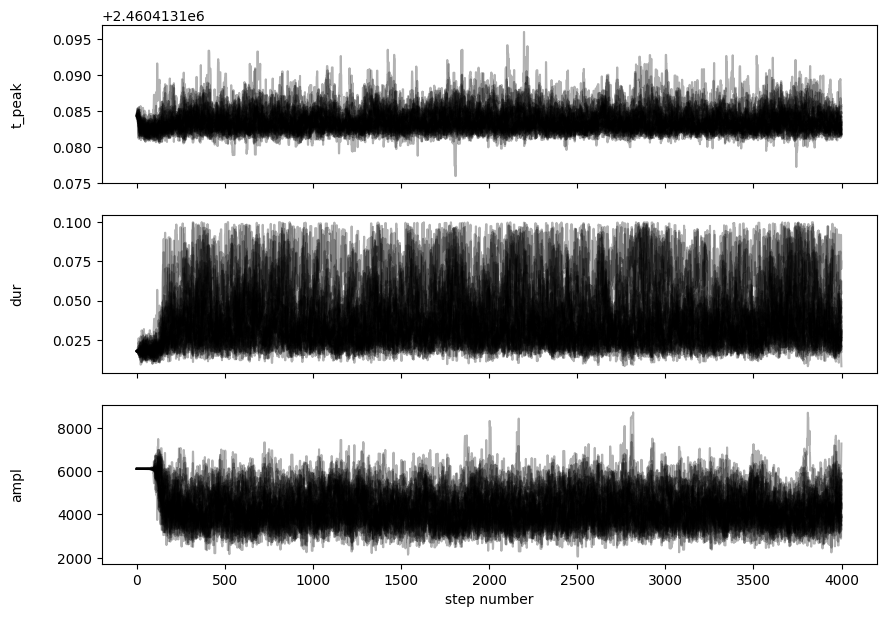

In [96]:
# plot the chains
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t_peak", "dur", "ampl"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.savefig(f"../plots/{file}/flares/hip67522_oneflare_model_mcmc_chains.png")

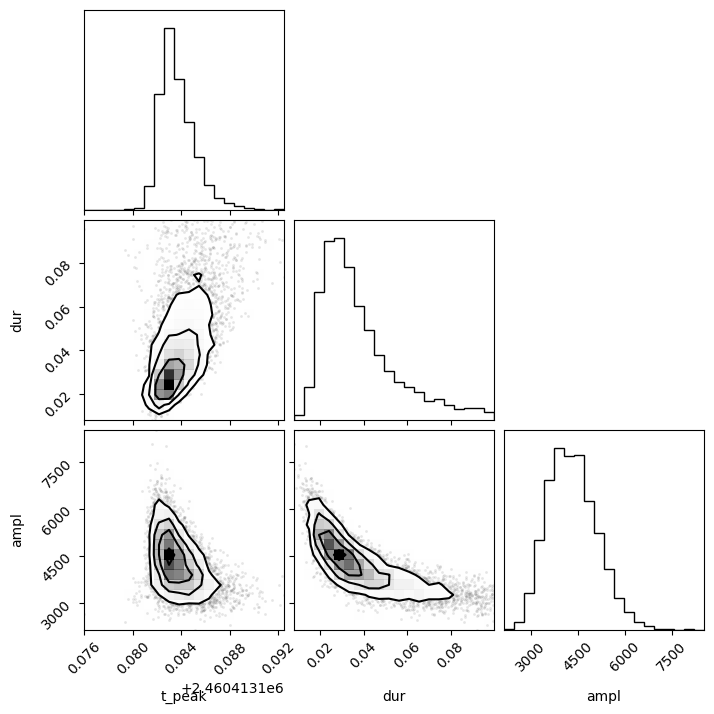

In [97]:
# plot the corner plot

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels)
plt.savefig(f"../plots/{file}/flares/hip67522_oneflare_model_mcmc_corner.png")

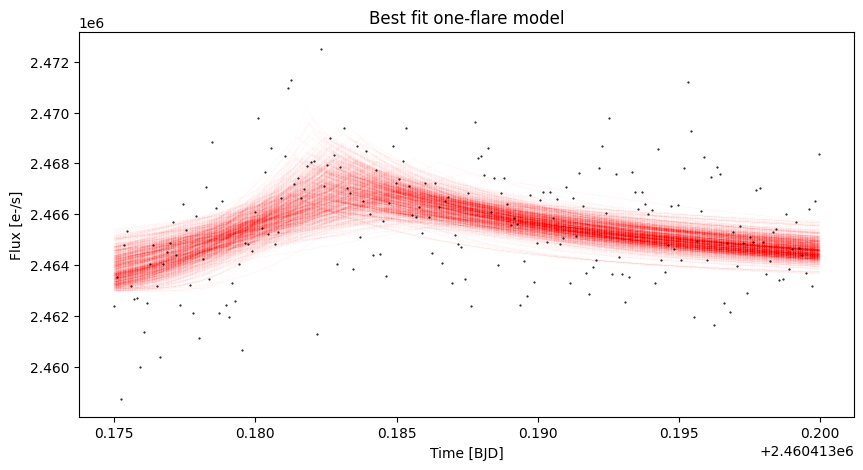

In [98]:
# plot the best fit model
t_peak, dur, ampl = np.median(flat_samples, axis=0)
plt.figure(figsize=(10, 5))

t_interpolate = np.linspace(t[flare_mask].min(), t[flare_mask].max(), 1000)

# sample 500 random samples from the chain
eds = []
for i in np.random.randint(len(flat_samples), size=500):
    sample = flat_samples[i]
    f_interpolate = flare_fit_model(t_interpolate, *sample) + newmed
    plt.plot(t_interpolate, f_interpolate,  ".", color="red", alpha=0.01, markersize=1)

    flc = FlareLightCurve(time=t_interpolate, flux = f_interpolate, flux_err=ferrstd)
    flc.it_med = newmed
    flc.detrended_flux = f_interpolate
    ed = equivalent_duration(flc, 0, len(t_interpolate)-1)  
    eds.append(ed)


plt.plot(t[flare_mask], f_flare, ".", markersize=1, color="black")

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")

plt.title("Best fit one-flare model")

plt.savefig(f"../plots/{file}/flares/hip67522_oneflare_model_bestfit.png")

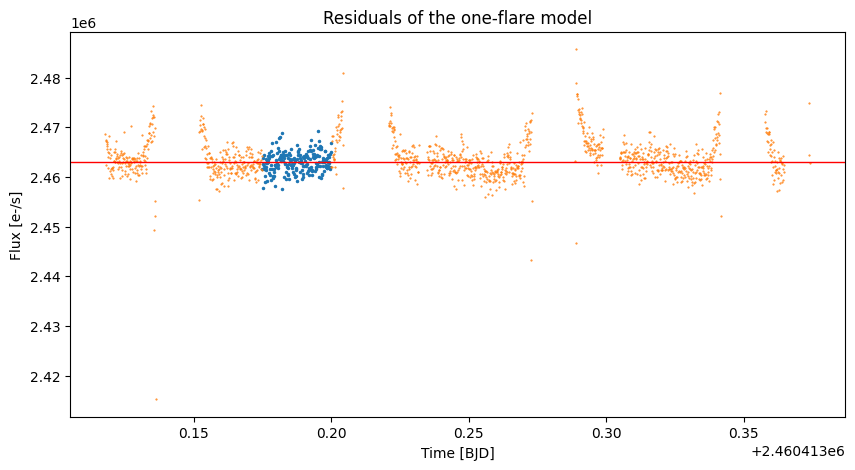

In [99]:
# subtract model from f_flare
residuals = f_flare - flare_fit_model(t[flare_mask], t_peak, dur, ampl) 

plt.figure(figsize=(10, 5))
plt.plot(t[flare_mask], residuals, ".", markersize=3)
plt.plot(t[~flare_mask], newf_sub[~flare_mask], ".", markersize=1)
plt.axhline(newmed, color="red", lw=1)
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Residuals of the one-flare model")
plt.savefig(f"../plots/{file}/flares/hip67522_oneflare_model_residuals.png")

In [102]:
if two_flare:
    # now fit a two component model to the flare light curve
    def flare_fit_model(t, t_peak, dur, ampl, t_peak2, dur2, ampl2):
        return flare_model(parametrization, t, t_peak, dur, ampl) + flare_model(parametrization, t, t_peak2, dur2, ampl2)


    tpeak2 = t_peak + 0.01
    dur2 = 0.02
    ampl2 = 0.04*newmed
    popt, pcov = curve_fit(flare_fit_model, t[flare_mask], f_flare-newmed, p0=[t_peak, dur, ampl, t_peak, dur, ampl])

    # plt.plot(t[flare_mask], flare_fit_model(t[flare_mask], *popt), ".", markersize=1, color="red")
    # plt.plot(t[flare_mask], f_flare-med, ".", markersize=1, color="black")


    ferrstd = np.std(newf_sub[~flare_mask])

    def log_likelihood(theta, t, f, ferrstd):
        t_peak, dur, ampl, t_peak2, dur2, ampl2 = theta
        model = flare_fit_model(t, t_peak, dur, ampl, t_peak2, dur2, ampl2)
        return -0.5 * np.sum((f - model)**2 / ferrstd**2)

    def log_prior(theta):
        t_peak, dur, ampl, t_peak2, dur2, ampl2 = theta
        if  ((t[flare_mask][0] < t_peak < t[flare_mask][-1]) and 
            (0.0 < dur < 0.1) and 
            (0.01 < ampl < 1e7) and 
            (t[flare_mask][0] < t_peak2 < t[flare_mask][-1]) and 
            (0.0 < dur2 < 0.1) and 
            (0.01 < ampl2 < 1e7)):
            return 0.0
        return -np.inf

    def log_probability(theta, t, f, ferrstd):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, t, f, ferrstd)

    ndim = 6
    nwalkers = 32
    nsteps = 20000

    pos = popt + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t[flare_mask], f_flare-newmed, ferrstd))

    sampler.run_mcmc(pos, nsteps, progress=True);

    # plot the chains
    fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["t_peak", "dur", "ampl", "t_peak2", "dur2", "ampl2"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.savefig(f"../plots/{file}/flares/hip67522_twoflare_model_mcmc_chains.png")

    # plot the corner plot

    flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)

    fig = corner.corner(
        flat_samples, labels=labels, truths=popt
    )

    plt.savefig(f"../plots/{file}/flares/hip67522_twoflare_model_mcmc_corner.png")

    # plot the best fit model
    t_peak, dur, ampl, t_peak2, dur2, ampl2 = np.median(flat_samples, axis=0)
    plt.figure(figsize=(10, 5))

    # sample 100 random samples from the chain

    for i in np.random.randint(len(flat_samples), size=400):
        sample = flat_samples[i]
        plt.plot(t[flare_mask], flare_fit_model(t[flare_mask], *sample),  ".", color="black", alpha=0.01, markersize=1)


    plt.plot(t[flare_mask], f_flare-newmed, ".", markersize=1, color="black")

    plt.xlabel("Time [BJD]")
    plt.ylabel("Flux [e-/s]")
    plt.title("Best fit two-flare model")

    plt.savefig(f"../plots/{file}/flares/hip67522_twoflare_model_bestfit.png")



    # interpolate the flare model in the gaps
    t_peak, dur, ampl, t_peak2, dur2, ampl2 = np.median(flat_samples, axis=0)
    t_interpolate = np.linspace(t[flare_mask].min(), t[flare_mask].max(), 1000)
    f_interpolate = flare_fit_model(t_interpolate, t_peak, dur, ampl, t_peak2, dur2, ampl2)

    # iterate over a 100 random samples from the chain
    eds = []
    plt.figure(figsize=(10, 5))

    for i in np.random.randint(len(flat_samples), size=500):
        sample = flat_samples[i]
        f_interpolate = flare_fit_model(t_interpolate, *sample)
        plt.plot(t_interpolate, f_interpolate, color="black", alpha=0.01, lw=1)

        flc = FlareLightCurve(time=t_interpolate, flux=f_interpolate+newmed, flux_err=ferrstd)
        flc.detrended_flux = f_interpolate + newmed
        flc.it_med = newmed

        ed = equivalent_duration(flc, 0, len(f_interpolate)-1)  
        eds.append(ed)

    plt.plot(t_interpolate, f_interpolate, color="black", alpha=0.01, lw=1, label="samples from posterior distribution")

    plt.plot(t_interpolate, f_interpolate, color="red", lw=1, label="best-fit model")

    plt.plot(t[flare_mask], f_flare-newmed, ".", markersize=1, color="black", label="de-trended flare light curve")
    plt.xlim(t[flare_mask].min(), t[flare_mask].max())
    plt.axhline(0, color="black", lw=1)
    plt.xlabel("Time [BJD]")
    plt.ylabel("Flare flux [e-/s]")

    plt.legend(loc=0, frameon=False)
    plt.title("Two-flare model")
    plt.savefig(f"../plots/{file}/flares/hip67522_twoflare_model_posterior.png")

    # plot the residuals
    residuals = f_flare - flare_fit_model(t[flare_mask], t_peak, dur, ampl, t_peak2, dur2, ampl2)

    plt.figure(figsize=(10, 5))
    plt.plot(t[flare_mask], residuals-newmed, ".", markersize=3)

    plt.axhline(0, color="red", lw=1)
    plt.xlabel("Time [BJD]")
    plt.ylabel("Flux [e-/s]")
    plt.title("Residuals of the two-flare model")
    plt.savefig(f"../plots/{file}/flares/hip67522_twoflare_model_residuals.png")



NameError: name 'two_flare' is not defined

(2.1587183985525407, 0.23662332635536756)

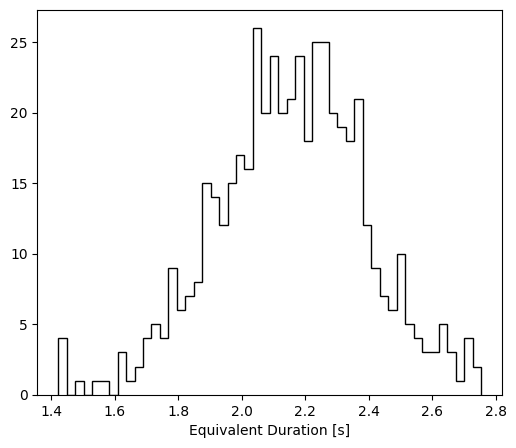

In [100]:
plt.figure(figsize=(6, 5))
plt.hist(eds, histtype="step", bins=50, color="black")
plt.xlabel("Equivalent Duration [s]")
plt.savefig(f"../plots/{file}/flares/hip67522_twoflare_model_posterior_ED.png")

ED = np.median(eds)
EDerr = np.std(eds)
ED, EDerr

In [101]:
 # read TESS response function
tess_resp = pd.read_csv("../data/tess-response-function-v2.0.csv", skiprows=7, names=["wav", "resp"], header=None)
wav, resp = tess_resp.wav.values, tess_resp.resp.values

# effective temperature of Scholz's star in K from Pecaut and Mamajek 2013
teff = 5650 # +- 75

# radius of Scholz's star in Solar radii from Pecaut and Mamajek 2013
radius = 1.392 # +- 0.05

print(f"Effective temperature: {teff:.0f} K")
print(fr"Radius: {radius:.3f} solar radii")

# calculate bolometric flare energy
print("\n We use an 14000K flare temperature, accounting for decreasing flare temperature with later spectral type.")
print("See Maas et al. (2022)")
bol_energy = flare_factor(teff, radius, wav, resp,  tflare=10000) * ED * u.s


print("\nBolometric flare energy in ergs:")
print(f"{bol_energy:.2e}")


Effective temperature: 5650 K
Radius: 1.392 solar radii

 We use an 14000K flare temperature, accounting for decreasing flare temperature with later spectral type.
See Maas et al. (2022)

Bolometric flare energy in ergs:
7.45e+33 erg


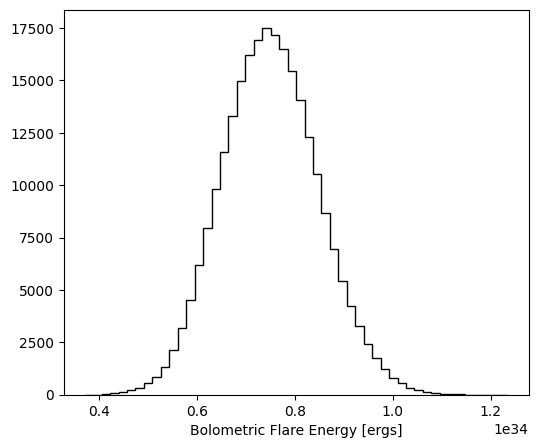

In [102]:
# sample the posterior distribution of the flare energy using the MCMC samples on ED, and teff and radius with Gaussian errors
teff = np.random.normal(5650, 75, 500)
radius = np.random.normal(1.392, 0.05, 500)

# calculate the bolometric flare energy for each sample
bol_energies = flare_factor(teff.reshape((500,1)), radius.reshape((500,1)), wav, resp,  tflare=10000) * np.random.choice(eds, 500) * u.s

# calculate the mean and standard deviation of the bolometric flare energy
mean_bol_energy = np.mean(bol_energies)
std_bol_energy = np.std(bol_energies)

# plot the distribution of the bolometric flare energy
plt.figure(figsize=(6, 5))
plt.hist(bol_energies.value.flatten(), histtype="step", bins=50, color="black")
plt.xlabel("Bolometric Flare Energy [ergs]")
plt.savefig(f"../plots/{file}/flares/hip67522_twoflare_model_posterior_bolometric_energy.png")

# write the results to file
with open(f"../results/cheops_flares.csv", "a") as f:
    # f.write("date,bol_energy,bol_energy_value,ED,EDerr,mean_bol_energy,std_bol_energy,egress,tmin,tmax,parametrization\n")
    f.write(f"{file},{bol_energy:.2e},{bol_energy.value:.2e},{ED:.2e}," +
            f"{EDerr:.2e},{mean_bol_energy},{std_bol_energy},{egress}," + 
            f"{tmin},{tmax},{parametrization}\n")
